## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
# import zipfile
# import tarfile

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils import robust_percentile_normalization, shift_stimulus_to_phosphene_centroid

from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from scipy.ndimage import gaussian_filter1d


from phosphene.uniformity import DynamicAmplitudeNormalizer
from components.SeparableModulated2d import SeparableModulatedConv2d
from phosphene.density import VisualFieldMapper

import math
import pickle  

# Load files

In [2]:
rgb_file_name = "rgb_1"
depth_file_name = "depth_1"

# Path to the video file
video_path = f"../data/depth/example1/{rgb_file_name}.mp4"
depth_video_path = f"../data/depth/example1/{depth_file_name}.mp4"

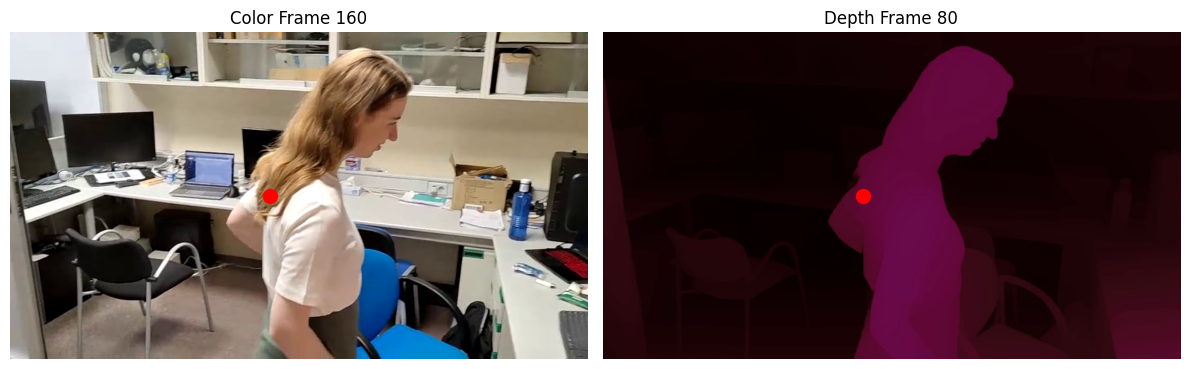

In [3]:
# Index of the color-video frame to inspect
# frame_i = 410
frame_i = 160
# Example gaze point in normalized coordinates (center)
gaze_point = [0.45, 0.5, 0]

# Open both video captures
cap_color = cv2.VideoCapture(video_path)
cap_depth = cv2.VideoCapture(depth_video_path)

# Retrieve FPS for each stream
fps_color = cap_color.get(cv2.CAP_PROP_FPS)
fps_depth = cap_depth.get(cv2.CAP_PROP_FPS)

# Compute time (in seconds) for the chosen color frame
time_sec = frame_i / fps_color

# Map to the corresponding depth frame index
frame_depth_i = int(time_sec * fps_depth)

# Seek both streams
cap_color.set(cv2.CAP_PROP_POS_FRAMES, frame_i)
cap_depth.set(cv2.CAP_PROP_POS_FRAMES, frame_depth_i)

# Read frames
ret_c, frame_c = cap_color.read()
ret_d, frame_d = cap_depth.read()
# reshape depth frame if necessary to dimensions of color frame
if ret_d:
    if frame_d.shape[:2] != frame_c.shape[:2]:
        frame_d = cv2.resize(frame_d, (frame_c.shape[1], frame_c.shape[0]))

if not (ret_c and ret_d):
    print('Error: Could not read one or both frames.')
else:
    # Compute gaze pixel in color frame
    h_c, w_c = frame_c.shape[:2]
    gaze_x_c = int(gaze_point[0] * w_c)
    gaze_y_c = int(gaze_point[1] * h_c)
    # Overlay gaze point
    # cv2.circle(frame_c, (gaze_x_c, gaze_y_c), radius=10, color=(0, 0, 255), thickness=-1)
    

    # Prepare depth frame for visualization (convert to BGR if grayscale)
    if len(frame_d.shape) == 2:
        frame_d_vis = cv2.cvtColor(frame_d, cv2.COLOR_GRAY2BGR)
    else:
        frame_d_vis = frame_d.copy()
    h_d, w_d = frame_d_vis.shape[:2]
    gaze_x_d = int(gaze_point[0] * w_d)
    gaze_y_d = int(gaze_point[1] * h_d)
    # cv2.circle(frame_d_vis, (gaze_x_d, gaze_y_d), radius=10, color=(0, 0, 255), thickness=-1)

    # Convert color frame to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB)

    # Display both frames side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(frame_rgb)
    ax1.scatter(gaze_x_c, gaze_y_c, color='red', s=100, label='Gaze Point')
    ax1.set_title(f'Color Frame {frame_i}')
    ax1.axis('off')

    ax2.imshow(frame_d_vis)
    ax2.set_title(f'Depth Frame {frame_depth_i}')
    ax2.scatter(gaze_x_d, gaze_y_d, color='red', s=100, label='Gaze Point')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Release resources
cap_color.release()
cap_depth.release()

# Simulator

480


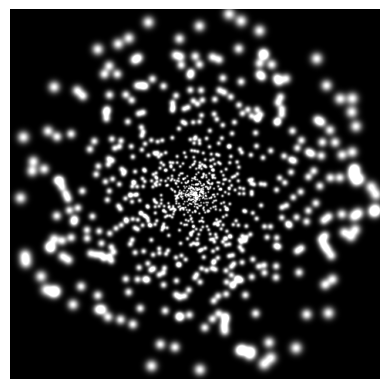

In [4]:
frame_width = frame_c.shape[1]
frame_height = frame_c.shape[0]

# Define the frame resolution and crop size
camera_fov = 40 # Camera field of view in degrees, this is an estimate, i can't find online what the actual fov is
phosphene_fov = 20

ratio = phosphene_fov / camera_fov 
crop_size = int(frame_width * ratio)
print(crop_size)

# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')
params['run']['resolution'] = [crop_size, crop_size]
params['run']['view_angle'] = 16

# Get phosphene coordinates...
# n_phosphenes = 1024
# phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# open from pickle file:
path = '../electrode_schemes/defaultcoordinatemap_1024.pickle' # view_angle = 16
# path = '../electrode_schemes/4utaharrays.pickle' # view_angle = 16
# path = '../electrode_schemes/1utaharray.pickle' # view_angle = 0.5
# path = '../electrode_schemes/neuralink.pickle' # view_angle = 25
# path = '../electrode_schemes/utahRFs.pickle' # view_angle = 6

with open(path, 'rb') as f:
    phosphene_coords = pickle.load(f)

n_phosphenes = len(phosphene_coords)

# # for sampling from images/video
# sampling:
#   sampling_method: center #receptive_fields or center
#   RF_size: 0.5 # millimeters of cortical surface (when sampling receptive fields)
params['sampling']['sampling_method'] = 'center'  # 'receptive_fields' or 'center'
params['sampling']['RF_size'] = 0.5  # millimeters of cortical surface


# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

Loss = 0.0408:   3%|███▌                                                                                                                               | 11/400 [00:00<00:06, 58.65iter/s]

Loss = 0.0077: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 91.85iter/s]


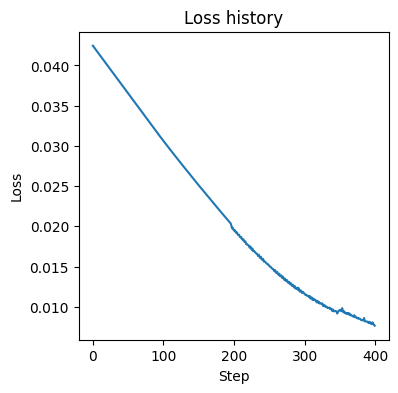

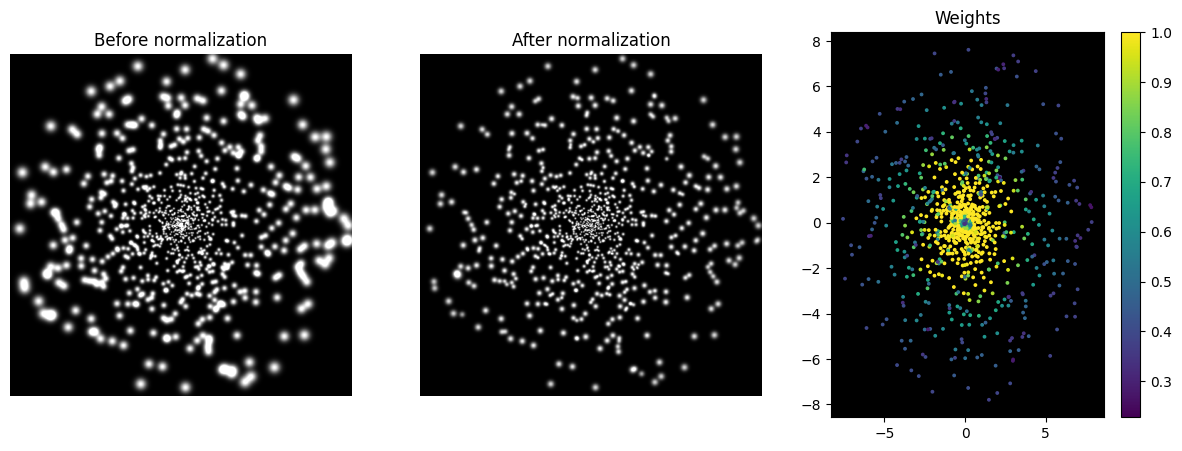

In [5]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.1,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.01,
    steps=400,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# SCAPE

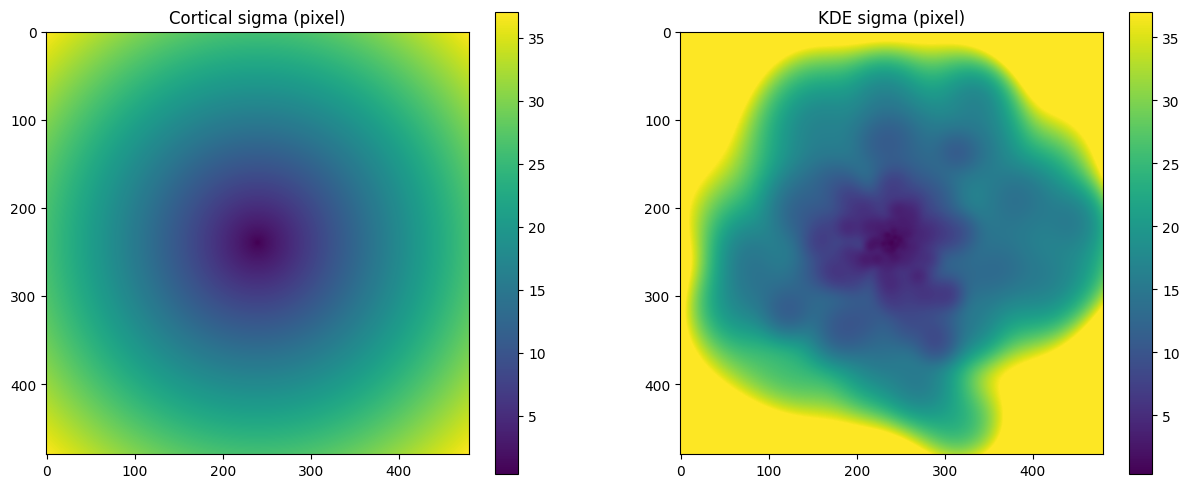

Centroid of cortical density: (0.04, -0.02) degrees


In [6]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=n_phosphenes)
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=6, alpha=1.0, total_phosphenes=n_phosphenes)
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

# plot sigma_cortical_pix, sigma_kde_pix

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()
# Find centroid
x_centroid, y_centroid = mapper.centroid_of_density(density_kde)
print(f'Centroid of cortical density: ({x_centroid:.2f}, {y_centroid:.2f}) degrees')

In [7]:
sigma_map_tensor = torch.Tensor(sigma_kde_pix).float().cuda().detach()

layer = SeparableModulatedConv2d(
    in_channels=1,
    sigma_map=sigma_map_tensor).cuda()

# Video processing

(480, 480, 3)


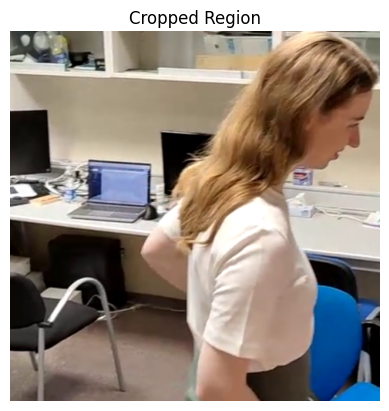

In [8]:
def crop_frame(frame, gaze_x, gaze_y, crop_size, resize=None):
    h, w, _ = frame.shape
    x_center = int(gaze_x * w)
    y_center = int(gaze_y * h)

    frame = shift_stimulus_to_phosphene_centroid(
        frame,
        centroid=(x_centroid, y_centroid),
        fov=params['run']['view_angle'],
        mode='constant',
        cval=0.0
    )

    # Calculate desired crop boundaries (might be outside frame)
    desired_x1 = x_center - crop_size // 2
    desired_y1 = y_center - crop_size // 2
    desired_x2 = desired_x1 + crop_size
    desired_y2 = desired_y1 + crop_size

    # Calculate how much we're out of bounds on each side
    pad_left = max(0, -desired_x1)
    pad_right = max(0, desired_x2 - w)
    pad_top = max(0, -desired_y1)
    pad_bottom = max(0, desired_y2 - h)

    # Clamp coordinates to actual frame dimensions
    x1 = max(0, desired_x1)
    y1 = max(0, desired_y1)
    x2 = min(w, desired_x2)
    y2 = min(h, desired_y2)

    # Perform the actual crop
    cropped_frame = frame[y1:y2, x1:x2]

    # Apply asymmetric padding only where needed
    if pad_left + pad_right + pad_top + pad_bottom > 0:
        cropped_frame = cv2.copyMakeBorder(
            cropped_frame,
            pad_top, pad_bottom,
            pad_left, pad_right,
            cv2.BORDER_REFLECT
        )

    # Final resize if requested
    if resize and resize != crop_size:
        cropped_frame = cv2.resize(cropped_frame, (resize, resize))

    return cropped_frame

frame = frame_c.copy()  # Use the color frame for cropping
gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates


if ret_c:
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    print(cropped.shape)

    # Display the cropped region
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Could not retrieve frame {frame_i}.")

(544, 960, 3)
(544, 960, 3)


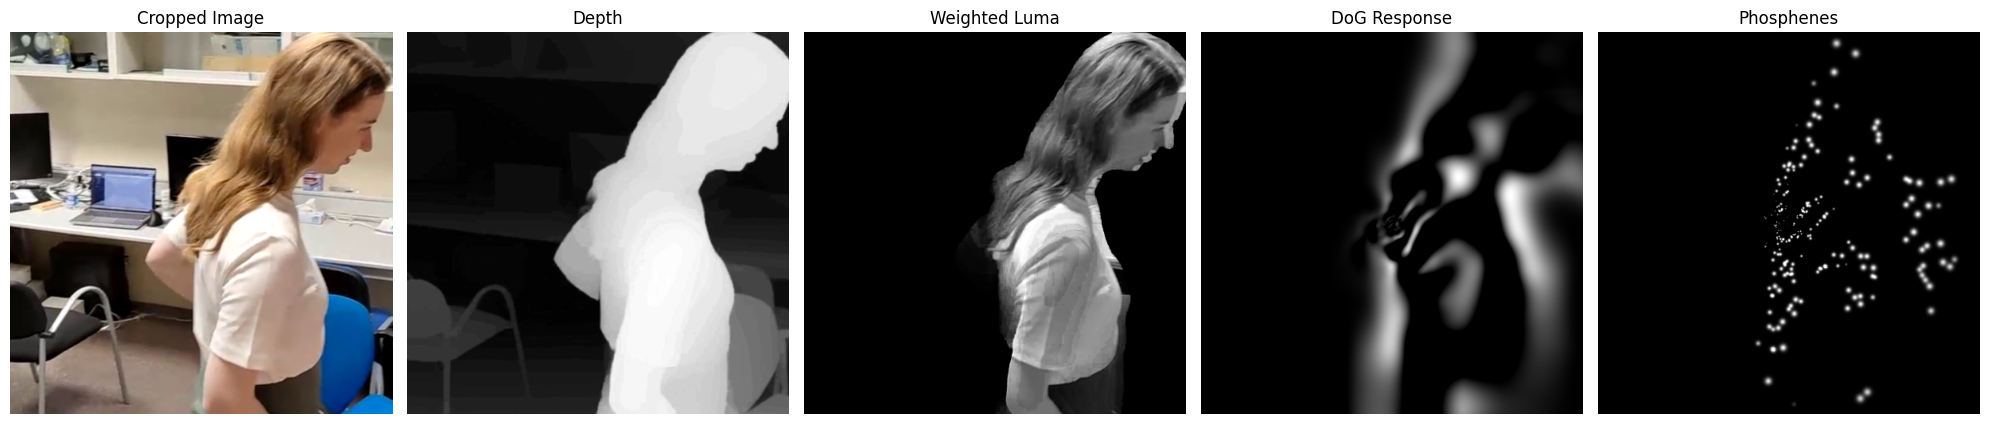

In [26]:
# 0) Start with your OpenCV crop as before: BGR in [0,1]
#    Call it `cropped`: shape (H, W, 3)
gaze_x, gaze_y = gaze_point[0], gaze_point[1]  # Normalized coordinates
crop_size = int(frame_width * ratio)  
orig_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
print(orig_rgb.shape)
cropped = crop_frame(orig_rgb, gaze_x, gaze_y, crop_size, crop_size)

# load depth in color
orig_depth = cv2.cvtColor(frame_d_vis, cv2.COLOR_BGR2RGB)
print(orig_depth.shape)
# crop depth frame
cropped_depth = crop_frame(orig_depth, gaze_x, gaze_y, crop_size, crop_size)


# 1) Compute weighted‐luma manually
#    (we need a 1-channel tensor for the new module)
rgb_w = torch.tensor([0.2126, 0.7152, 0.0722], device='cuda')
# convert to tensor [3,H,W]
img_t = torch.from_numpy(cropped.transpose(2,0,1)).float().cuda()
# weighted sum over channel → [H,W]
luma2d = (rgb_w.view(3,1,1) * img_t).sum(dim=0)
# add batch & channel dims → [1,1,H,W]
image_tensor = luma2d.unsqueeze(0).unsqueeze(0) / 255
# depth_tensor, convert from RGB to grayscale [1,1,H,W]
depth_tensor = torch.from_numpy(cropped_depth).float().cuda().mean(-1).unsqueeze(0).unsqueeze(0)
# normalize to [0,1] range
depth_tensor = (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min())
# depth_tensor = 1 - depth_tensor  # Invert depth for weighting

weighting = 'gaussian'  # Choose from: 'power_law', 'exponential_decay', 'sigmoid', 'gaussian', or None
if weighting == 'power_law':
# power law weighting
    γ = 2.0               # sharper fall-off for γ>1, milder for γ<1
    w = depth_tensor.pow(γ)
elif weighting == 'exponential_decay':
# exponential decay weighting
    α = 3.0               # controls rate of decay
    w = 1 - torch.exp(-α * depth_tensor)
elif weighting == 'sigmoid':
# sigmoid weighting
    β, D0 = 10.0, 0.5     # β controls slope, D0 the mid-point
    w = 1 - (1.0 / (1.0 + torch.exp(β * (depth_tensor - D0))))
elif weighting == 'gaussian':
    # gaussian
    D0, σ = 0.9, 0.1     # center and width of emphasis
    w = torch.exp(- (depth_tensor - D0)**2 / (2.0 * σ**2))
else:
    w = 1.0

weighted_image = image_tensor * w

# 2) Run your module (now single‐channel)
with torch.no_grad():
    response = layer(weighted_image).clamp(min=0)
response = (response - response.min()) / (response.max() - response.min())
response_disp = response[0,0].cpu().numpy()  # [H,W]

# 3) Stimulate / threshold / simulate
simulator.reset()
electrodes = simulator.sample_stimulus(response, rescale=True)
electrodes = robust_percentile_normalization(
    electrodes, amplitude,
    threshold=params['thresholding']['rheobase'],
    low_perc=5, high_perc=90, gamma=2/3
)
phos = simulator(electrodes * stim_weights)  # [1,1,H,W]
phos_disp = phos[0].cpu().numpy()          # [H,W]

# 4) Plot all three side by side
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.imshow(cropped)               # full‐color RGB
plt.title('Cropped Image')
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(depth_tensor[0,0].cpu().numpy(), cmap='gray')
plt.title('Depth')
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(weighted_image[0,0].cpu().numpy(), cmap='gray')
plt.title('Weighted Luma')
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(response_disp, cmap='gray')
plt.title('DoG Response')
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(phos_disp, cmap='gray')
plt.title('Phosphenes')
plt.axis('off')

plt.tight_layout()
plt.show()


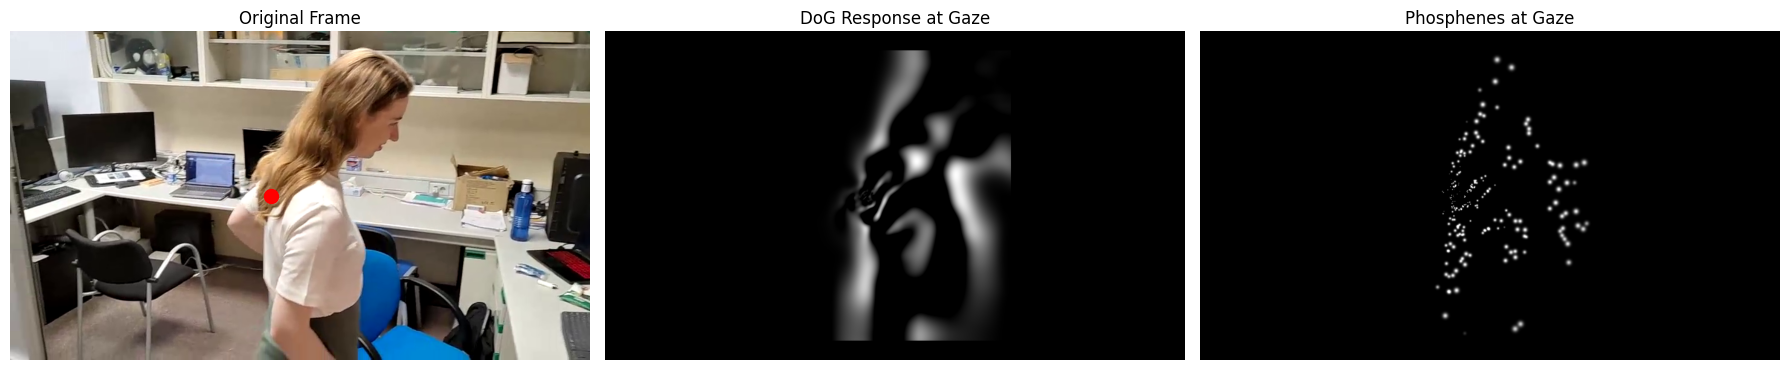

In [27]:
def insert_patch_on_black_canvas(frame_shape, patch, gaze_x, gaze_y):
    """
    Create a black canvas the size of `frame_shape`, and place `patch` at a location
    specified by the (normalized) gaze_x, gaze_y.  If the patch would lie partly
    outside the canvas, it’s just cropped—not padded in.

    Inputs:
    - frame_shape: (H, W, C) for RGB or (H, W) for grayscale
    - patch:       (h, w) or (h, w, c)
    - gaze_x, gaze_y: normalized coordinates in [0,1] (but we allow patch to extend off-canvas)

    Returns:
    - canvas: image with patch placed on black background (cropped at edges if needed)
    """
    canvas = np.zeros(frame_shape, dtype=patch.dtype)

    H, W = frame_shape[:2]
    h, w = patch.shape[:2]

    # compute patch’s intended top-left and bottom-right in canvas coords
    x1 = int(round(gaze_x * W)) - w // 2
    y1 = int(round(gaze_y * H)) - h // 2
    x2 = x1 + w
    y2 = y1 + h

    # compute overlap with canvas
    canvas_x1 = max(x1, 0)
    canvas_y1 = max(y1, 0)
    canvas_x2 = min(x2, W)
    canvas_y2 = min(y2, H)

    # compute corresponding patch region
    patch_x1 = max(0, -x1)
    patch_y1 = max(0, -y1)
    patch_x2 = patch_x1 + (canvas_x2 - canvas_x1)
    patch_y2 = patch_y1 + (canvas_y2 - canvas_y1)

    # place
    if patch.ndim == 2 and canvas.ndim == 3:
        # grayscale patch onto color canvas
        canvas[canvas_y1:canvas_y2, canvas_x1:canvas_x2, :] = patch[patch_y1:patch_y2, patch_x1:patch_x2, None]
    else:
        canvas[canvas_y1:canvas_y2, canvas_x1:canvas_x2] = patch[patch_y1:patch_y2, patch_x1:patch_x2]

    return canvas

# Resize to smaller patch
Hc, Wc = crop_size, crop_size
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame_depth = cv2.cvtColor(frame_d_vis, cv2.COLOR_BGR2RGB)

frame_rgb = frame_rgb

response_disp = cv2.resize(response_disp, (Wc, Hc))
phos_disp = cv2.resize(phos_disp, (Wc, Hc))

resp_patch = cv2.resize(response_disp, (Wc, Hc))
phos_patch = cv2.resize(phos_disp, (Wc, Hc))

# Convert to uint8 grayscale
resp_u8 = (resp_patch * 255).astype(np.uint8)
phos_u8 = (phos_patch * 255).astype(np.uint8)

# Insert on black canvas
frame_shape = frame_rgb.shape if frame_rgb.ndim == 3 else frame_rgb.shape + (1,)
canvas_resp = insert_patch_on_black_canvas(frame_shape, resp_u8, gaze_x, gaze_y)
canvas_phos = insert_patch_on_black_canvas(frame_shape, phos_u8, gaze_x, gaze_y)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(frame_rgb)
plt.scatter(gaze_x * frame_rgb.shape[1], gaze_y * frame_rgb.shape[0], color='red', s=100)
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(canvas_resp[:, :, ::-1] if canvas_resp.ndim == 3 else canvas_resp, cmap="gray")
plt.title("DoG Response at Gaze")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(canvas_phos[:, :, ::-1] if canvas_phos.ndim == 3 else canvas_phos, cmap="gray")
plt.title("Phosphenes at Gaze")
plt.axis("off")

plt.tight_layout()
plt.show()


# Smooth Gaze Data for blinks

In [14]:
# # plot eye gaze data
# plt.figure(figsize=(8, 6))
# # scatterplot x,y gaze data
# plt.scatter(gaze_data[:,0], gaze_data[:,1], s=1)
# plt.title('Gaze Data')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [15]:
# blink_epsilon = 0.05
# # find blinks where x or y is less than epsilon or more than 1-epsilon
# blink_indices = np.where(
#     (gaze_data[:,0] < blink_epsilon) | (gaze_data[:,0] > 1-blink_epsilon) |
#     (gaze_data[:,1] < blink_epsilon) | (gaze_data[:,1] > 1-blink_epsilon)
# )[0]

# # n many blnks found
# print(len(blink_indices), 'blinks found')

In [16]:
# # wherever the blink is, set the gaze point to the last valid gaze point
# removed_blinks_gaze_data = gaze_data.copy()
# for i in blink_indices:
#     removed_blinks_gaze_data[i] = removed_blinks_gaze_data[i-1]

# # plot eye gaze data
# plt.figure(figsize=(8, 6))
# # scatterplot x,y gaze data
# plt.scatter(removed_blinks_gaze_data[:,0], removed_blinks_gaze_data[:,1], s=1)
# plt.title('Removed blinks Gaze Data')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()


In [17]:
# # smooth the first 2 columns of the gaze data
# smoothed_gaze_data = removed_blinks_gaze_data.copy()

# sigma = 2  # Adjust sigma based on desired smoothness
# # Apply Gaussian smoothing to both X and Y coordinates
# smoothed_gaze_data[:,0] = gaussian_filter1d(removed_blinks_gaze_data[:,0], sigma=sigma, mode='nearest')
# smoothed_gaze_data[:,1] = gaussian_filter1d(removed_blinks_gaze_data[:,1], sigma=sigma, mode='nearest')


# # plot eye gaze data
# plt.figure(figsize=(26, 6))
# # scatterplot x,y gaze data

# plt.subplot(1, 2, 1)
# plt.plot(removed_blinks_gaze_data[:,0], label='X')
# plt.plot(removed_blinks_gaze_data[:,1], label='Y')
# plt.title('Gaze Data')
# plt.xlabel('Frame')
# plt.ylabel('Value')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(smoothed_gaze_data[:,0], label='X')
# plt.plot(smoothed_gaze_data[:,1], label='Y')
# plt.title('Smoothed Gaze Data')
# plt.xlabel('Frame')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# Video processing

In [30]:
import cv2
import numpy as np
import torch
from torchvision import transforms

weighting = 'gaussian'  # or 'exponential_decay', 'sigmoid', 'gaussian'

file_name = "rgb_1"  # or "depth_1"
file_name_depth = "depth_1"  # or "rgb_1"
# gaze_data_path = f"../data/EGTEA/Gaze_Data/gaze_data/gaze_data/{file_name}.txt"
video_path = f"../data/depth/example1/{file_name}.mp4"
depth_video_path = f"../data/depth/example1/{file_name_depth}.mp4"
out_path = f"../out/{file_name}_depth{weighting}.mp4"

stack = 'horizontal'  # or 'vertical'
start_time_sec = 0
video_duration_sec = 50

temporal_dynamics = False

cap = cv2.VideoCapture(video_path)
cap_depth = cv2.VideoCapture(depth_video_path)
actual_fps = cap.get(cv2.CAP_PROP_FPS)
depth_fps = cap_depth.get(cv2.CAP_PROP_FPS)
if actual_fps != depth_fps:
    print(f"Warning: FPS mismatch between color ({actual_fps}) and depth ({depth_fps}) videos. Using color FPS.")
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_nr_start = int(start_time_sec * actual_fps)
max_n_frames = int((start_time_sec + video_duration_sec) * actual_fps)
max_n_frames = min(max_n_frames, total_frames)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
out_shape = (3 * frame_width, 2 * frame_height) if stack == 'horizontal' else (2 * frame_width, 3 * frame_height)
out = cv2.VideoWriter(out_path, fourcc, actual_fps, out_shape, isColor=True)

print(f"Opening writer at {out_path!r}: size={(out_shape,)} fps={actual_fps:.2f}")
print("Writer opened:", out.isOpened())

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr_start)
cap_depth.set(cv2.CAP_PROP_POS_FRAMES, frame_nr_start*depth_fps / actual_fps)
current_frame = frame_nr_start

simulator.reset()

while current_frame < max_n_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # convert fps to depth frame index
    depth_frame_index = int(current_frame * depth_fps / actual_fps)
    cap_depth.set(cv2.CAP_PROP_POS_FRAMES, depth_frame_index)
    ret_depth, frame_depth = cap_depth.read()
    if not ret_depth:
        print(f"Warning: Could not read depth frame {current_frame}. Continuing with color frame only.")
        frame_depth = np.zeros_like(frame)
    # resize to be the same dimensions as the color frame
    if frame_depth.shape[:2] != frame.shape[:2]:
        frame_depth = cv2.resize(frame_depth, (frame.shape[1], frame.shape[0]))


    # gaze_point = smoothed_gaze_data[current_frame, :]
    # if gaze_point[2] == 4:
    #     current_frame += 1
    #     continue
    gaze_point = [0.5, 0.5, 0]  # Use a fixed gaze point for now

    gaze_x, gaze_y = gaze_point[0], gaze_point[1]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
    cropped = crop_frame(frame, gaze_x, gaze_y, crop_size=crop_size, resize=None)
    cropped_depth = crop_frame(frame_depth, gaze_x, gaze_y, crop_size=crop_size, resize=None)

    # Convert cropped BGR to RGB and compute grayscale (luma)
    rgb = cropped[..., ::-1] / 255.0
    rgb_tensor = torch.from_numpy(rgb.transpose(2, 0, 1)).float().cuda()
    rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722], device='cuda').view(3, 1, 1)
    grayscale = (rgb_tensor * rgb_weights).sum(dim=0).unsqueeze(0).unsqueeze(0)

    depth_tensor = torch.from_numpy(cropped_depth).float().cuda().mean(dim=-1).unsqueeze(0).unsqueeze(0)
    depth_tensor = (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min())

    if weighting == 'power_law':
    # power law weighting
        γ = 2.0               # sharper fall-off for γ>1, milder for γ<1
        w = depth_tensor.pow(γ)
    elif weighting == 'exponential_decay':
    # exponential decay weighting
        α = 5.0               # controls rate of decay
        w = 1 - torch.exp(-α * depth_tensor)
    elif weighting == 'sigmoid':
    # sigmoid weighting
        β, D0 = 10.0, 0.5     # β controls slope, D0 the mid-point
        w = 1 - (1.0 / (1.0 + torch.exp(β * (depth_tensor - D0))))
    elif weighting == 'gaussian':
        # gaussian
        D0, σ = 0.9, 0.1     # center and width of emphasis
        w = torch.exp(- (depth_tensor - D0)**2 / (2.0 * σ**2))
    else:
        w = 1.0

    weighted_image = grayscale * w

    with torch.no_grad():
        response = layer(weighted_image).clamp(min=0)
    response = (response - response.min()) / (response.max() - response.min())

    if not temporal_dynamics:
        simulator.reset()
    electrodes = simulator.sample_stimulus(response, rescale=True)
    electrodes = robust_percentile_normalization(
        electrodes, amplitude,
        threshold=params['thresholding']['rheobase'],
        low_perc=5, high_perc=90, gamma=2/3
    )
    phosphenes = simulator(electrodes * stim_weights)[0].cpu().numpy()

    # Overlay on black canvas at gaze position
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    canvas_shape = frame_rgb.shape[:2]#.squeeze(-1)
    weighted_u8 = (weighted_image[0, 0].cpu().numpy() * 255).astype(np.uint8)
    resp_u8 = (response[0, 0].cpu().numpy() * 255).astype(np.uint8)
    phos_u8 = (phosphenes * 255).astype(np.uint8)
    depth_u8 = (depth_tensor[0, 0].cpu().numpy() * 255).astype(np.uint8)

    canvas_resp = insert_patch_on_black_canvas(canvas_shape, resp_u8, gaze_x, gaze_y)
    canvas_phos = insert_patch_on_black_canvas(canvas_shape, phos_u8, gaze_x, gaze_y)
    canvas_weighted = insert_patch_on_black_canvas(canvas_shape, weighted_u8, gaze_x, gaze_y)
    canvas_depth = insert_patch_on_black_canvas(canvas_shape, depth_u8, gaze_x, gaze_y)

    # Convert grayscale overlays to RGB if needed
    canvas_resp = np.stack([canvas_resp]*3, axis=-1) if canvas_resp.ndim == 2 else canvas_resp
    canvas_phos = np.stack([canvas_phos]*3, axis=-1) if canvas_phos.ndim == 2 else canvas_phos
    canvas_weighted = np.stack([canvas_weighted]*3, axis=-1) if canvas_weighted.ndim == 2 else canvas_weighted
    canvas_depth = np.stack([canvas_depth]*3, axis=-1) if canvas_depth.ndim == 2 else canvas_depth

    # Draw gaze point
    gaze_px = (int(gaze_x * frame_width), int(gaze_y * frame_height))
    cv2.circle(frame_rgb, gaze_px, 10, (255, 0, 0), -1)

    # Concatenate and write
    if stack == 'horizontal':
        cat1 = np.concatenate([frame_rgb, canvas_depth, np.zeros_like(canvas_weighted)], axis=1)
        cat2 = np.concatenate([canvas_weighted, canvas_resp, canvas_phos], axis=1)
        cat = np.concatenate([cat1, cat2], axis=0)
    elif stack == 'vertical':
        cat = np.concatenate([frame_rgb, canvas_depth, canvas_weighted, canvas_resp, canvas_phos], axis=0)

    out.write(cat.astype(np.uint8))
    current_frame += 1

cap.release()
out.release()
cv2.destroyAllWindows()

Opening writer at '../out/rgb_1_depthgaussian.mp4': size=((2880, 1088),) fps=29.76
Writer opened: True


/scratch-local/mappel.13169520/ipykernel_916459/586819432.py:123: RuntimeWarning: invalid value encountered in cast
  weighted_u8 = (weighted_image[0, 0].cpu().numpy() * 255).astype(np.uint8)
/scratch-local/mappel.13169520/ipykernel_916459/586819432.py:124: RuntimeWarning: invalid value encountered in cast
  resp_u8 = (response[0, 0].cpu().numpy() * 255).astype(np.uint8)
/scratch-local/mappel.13169520/ipykernel_916459/586819432.py:125: RuntimeWarning: invalid value encountered in cast
  phos_u8 = (phosphenes * 255).astype(np.uint8)
/scratch-local/mappel.13169520/ipykernel_916459/586819432.py:126: RuntimeWarning: invalid value encountered in cast
  depth_u8 = (depth_tensor[0, 0].cpu().numpy() * 255).astype(np.uint8)
